In [46]:

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from azureml.telemetry import set_diagnostics_collection
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
import sklearn.metrics 
from azureml.core.experiment import Experiment
import matplotlib.pyplot as plt


### kaggle
datain_dir = './'
datain_col_dir = './'
dataout_dir = ''

### mac
#datain_dir = '~/Data/diabetes/'
#datain_col_dir = '~/Data/diabetes/'
#dataout_dir = '~/Data/diabetes/'

### desktop
#from kaggle import proj #desktop
#datain_dir = proj.data_dir #desktop

In [2]:
import azureml.core
import os
from azureml.core import Workspace

subscription_id = os.getenv("SUBSCRIPTION_ID", default="a6c2a7cc-d67e-4a1a-b765-983f08c0423a")
resource_group = os.getenv("RESOURCE_GROUP", default="xiaoyzhu-mlworkspace")
workspace_name = os.getenv("WORKSPACE_NAME", default="xiaoyzhu-MLworkspace")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")


try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config(file_name="xiaoyzhuconfig.json")
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except:
    print("Workspace not accessible. Change your parameters or create a new workspace below")

Wrote the config file xiaoyzhuconfig.json to: F:\PatientHub\MLModels\Diabetes\aml_config\xiaoyzhuconfig.json
Workspace configuration succeeded. Skip the workspace creation steps below


In [3]:
import numpy as np

# Read in the data

In [4]:
df_raw_all = pd.read_csv(datain_dir + 'diabetic_data.csv') 
df_raw = df_raw_all.sample(10000)
df_raw = df_raw.replace('?', np.nan) 
df_raw.shape

(10000, 50)

# How many values are missing in patient records?

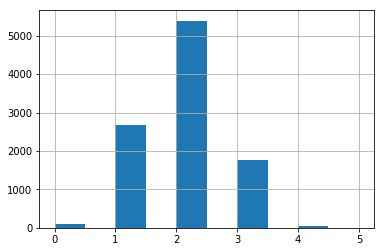

In [5]:
pt_sparsity = df_raw.isnull().apply(sum, axis=1)
%matplotlib inline
myhist = pt_sparsity.hist()

No need to drop patients due to missing values. 3 out of 50 missing values is not bad at all.

# Explore the variables, compile information about them

In [6]:
col_data = df_raw.apply(lambda s: set(s.unique()), axis=0).to_frame('uni_val')
col_data['nan_rat'] = df_raw.isnull().sum(axis=0)/len(df_raw)
col_data['n_uni_vals'] = col_data.uni_val.apply(len)
col_data['uni_vals_str'] = col_data[col_data.n_uni_vals<2000].uni_val.astype(str)
col_data = col_data.drop('uni_val', axis=1)
col_data['var_type'] = np.nan
col_data.to_csv(dataout_dir + "columns_raw.csv")

# Manual annotation of columns
I manually took columns_raw.csv and annotated columns based on whether they were ordered or categorical.  I saved my annotated file as columns.csv.  I will read this in later in the notebook.

In [7]:
col_data = pd.read_csv(datain_col_dir + "columns.csv", index_col=0)
col_data.sample(10)

,nan_rat,n_uni_vals,uni_vals_str,var_type,comment
acarbose,0.0000,2,"{'Steady', 'No'}",cat,NaN
troglitazone,0.0000,1,{'No'},drop,no information here!
encounter_id,0.0000,10000,NaN,drop,"ID value, not predictive"
num_procedures,0.0000,7,"{0, 1, 2, 3, 4, 5, 6}",cont,NaN
discharge_disposition_id,0.0000,21,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 17...",cat,NaN
tolbutamide,0.0000,2,"{'Steady', 'No'}",cat,NaN
weight,0.9673,8,"{nan, '[50-75)', '[75-100)', '[150-175)', '[10...",drop,too many missing values
readmitted,0.0000,3,"{'>30', '<30', 'NO'}",cat,NaN
glimepiride-pioglitazone,0.0000,1,{'No'},drop,no information here!
number_outpatient,0.0000,21,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",cont,NaN


# Generate boolean features for only most common medical specialties

In [8]:
#TODO recapture medical specialty
spec_counts = df_raw.medical_specialty.value_counts()
spec_counts.head(5).to_frame('num patients')

,num patients
InternalMedicine,1467
Family/GeneralPractice,763
Emergency/Trauma,717
Cardiology,514
Surgery-General,299


In [9]:
spec_thresh = 5
for (spec, count) in spec_counts.head(spec_thresh).iteritems():
    new_col = 'spec_' + str(spec)
    df_raw[new_col] = (df_raw.medical_specialty == spec)
    
df_raw.filter(regex='spec').sample(10)

,medical_specialty,spec_InternalMedicine,spec_Family/GeneralPractice,spec_Emergency/Trauma,spec_Cardiology,spec_Surgery-General
44014,Emergency/Trauma,False,False,True,False,False
25215,NaN,False,False,False,False,False
66896,NaN,False,False,False,False,False
82736,Emergency/Trauma,False,False,True,False,False
52499,Gastroenterology,False,False,False,False,False
100686,Emergency/Trauma,False,False,True,False,False
1753,InternalMedicine,True,False,False,False,False
1512,InternalMedicine,True,False,False,False,False
5533,NaN,False,False,False,False,False
63227,Cardiology,False,False,False,True,False


# Identify the most common diagnoses

In [10]:
diag_counts = (df_raw.diag_1.value_counts() + df_raw.diag_2.value_counts() + df_raw.diag_3.value_counts()).sort_values(ascending=False)
diag_counts.head(10).to_frame('num patients w diag')

,num patients w diag
250,1760.0
428,1749.0
276,1401.0
414,1271.0
401,1172.0
427,1118.0
599,675.0
496,541.0
403,538.0
486,532.0


# Generate boolean features for top N diagnoses

In [11]:
diag_thresh = 10
for (icd9, count) in diag_counts.head(diag_thresh).iteritems():
    new_col = 'diag_' + str(icd9)
    df_raw[new_col] = (df_raw.diag_1 == icd9)|(df_raw.diag_2 == icd9)|(df_raw.diag_3 == icd9)
    
df_raw.filter(regex='diag_').sample(10)

,diag_1,diag_2,diag_3,diag_250,diag_428,diag_276,diag_414,diag_401,diag_427,diag_599,diag_496,diag_403,diag_486
4920,410,414,401,False,False,False,True,True,False,False,False,False,False
59223,453,428,250,True,True,False,False,False,False,False,False,False,False
95754,789,789,250,True,False,False,False,False,False,False,False,False,False
39399,599,428,250,True,True,False,False,False,False,True,False,False,False
49759,185,584,599,False,False,False,False,False,False,True,False,False,False
21613,433,V12,250,True,False,False,False,False,False,False,False,False,False
70633,427,427,250,True,False,False,False,False,True,False,False,False,False
2945,296,309,309,False,False,False,False,False,False,False,False,False,False
67275,486,491,250.02,False,False,False,False,False,False,False,False,False,True
19509,434,403,784,False,False,False,False,False,False,False,False,True,False


# Clean the data

In [12]:
df_raw.age.sample(10)

40160     [50-60)
72028     [60-70)
93030     [70-80)
75356     [80-90)
88357     [70-80)
67250    [90-100)
28919     [70-80)
31778     [60-70)
39227     [80-90)
53734     [50-60)
Name: age, dtype: object

In [13]:
df_raw2 = pd.DataFrame(df_raw, copy=True) #preserve df_raw so I can rerun this step
df_raw2['age'] = df_raw2.age.str.extract('(\d+)-\d+')

to_drop = col_data[col_data.var_type.str.contains('drop')].index
df_raw2.drop(to_drop, axis=1, inplace=True)

#break out categorical variables into binaries
cat_cols = col_data[col_data.var_type.str.contains('cat')].index
df_raw2 = pd.get_dummies(df_raw2, columns=cat_cols)

#dropping these leaves up with one binary variable, ideal for simplicity
df_raw2.drop(['readmitted_<30','readmitted_>30'], axis=1, inplace=True)

#cleaning up outcome variable
df_raw2['is_readmitted'] = (df_raw2.readmitted_NO == 0)
df_raw2.drop('readmitted_NO', axis=1, inplace=True)

#ta daaaaaah, the data is ready to go
df = pd.DataFrame(df_raw2)
df.shape

(10000, 149)

In [14]:
df.age.sample(10)

77326    70
50819    80
3390     50
89310    70
22164    70
66339    80
68527    40
63669    70
64837    80
37282    80
Name: age, dtype: object

In [15]:
df.sample(15).sample(7, axis=1)

,rosiglitazone_Up,discharge_disposition_id_2,glipizide_Down,diag_428,repaglinide_Up,diag_401,A1Cresult_Norm
89409,0,0,0,False,0,False,0
69315,0,0,0,False,0,False,0
41299,0,0,0,False,0,False,0
61528,0,0,0,False,0,False,0
8379,0,0,0,False,0,True,0
19335,0,0,0,False,0,False,0
73748,0,0,0,False,0,False,0
6900,0,0,0,True,0,False,0
40827,0,0,0,False,0,False,0
76546,0,1,0,False,0,False,0


# Examine outcome variable

In [16]:
df.is_readmitted.value_counts()

False    5420
True     4580
Name: is_readmitted, dtype: int64

# Define this machine learning problem, impute, set aside test data

In [17]:
#partition training and test data, one balanced training set, all remaining for testing 
outcome_column = 'is_readmitted' 

#Imputing with outlying value since we are focusing on tree based methods
dff = df.fillna(-9999) 

#%% Split data for validation
X = dff.drop(outcome_column, axis=1) 
y = dff[outcome_column] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0) 

In [32]:
X_train

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,spec_InternalMedicine,...,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_28
61779,60,2,39,5,11,0,0,0,6,False,...,0,0,0,0,0,0,0,0,0,0
53648,60,1,47,0,8,0,0,0,9,True,...,0,0,0,0,0,0,0,0,0,0
57691,50,2,31,1,6,0,0,0,5,False,...,0,0,0,0,0,0,0,0,0,0
1577,60,10,65,4,13,0,0,0,9,False,...,0,0,0,0,0,0,0,0,0,0
35761,60,9,53,2,7,0,0,0,8,False,...,0,0,0,0,0,0,0,0,0,0
95300,70,4,62,0,7,0,0,0,9,False,...,0,0,0,0,0,0,0,0,0,0
54324,60,7,32,5,24,0,0,0,9,False,...,0,0,0,0,0,0,0,0,0,0
27367,20,4,17,1,19,0,0,0,9,False,...,0,0,0,0,0,0,0,0,0,0
73635,20,7,57,0,5,0,0,0,7,False,...,0,0,0,0,0,0,0,0,0,0
53376,70,3,57,0,6,0,0,3,8,True,...,1,0,0,0,0,0,0,0,0,0


In [33]:
type(y_train)

pandas.core.series.Series

In [34]:
y_train_array = np.array(y_train.values.tolist())
y_train_array

array([False, False, False, ...,  True,  True,  True])

# AML Fit data to Random Forest model, trying different subsets of variables


In [18]:
set_diagnostics_collection(send_diagnostics = True)

Turning diagnostics collection on. 


In [54]:
import logging
experiment = Experiment(ws, "Diabetes_prediction")
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 60,
                             iterations = 5,
                             n_cross_validations = 3,
                             verbosity = logging.INFO,
                             X = X_train, 
                             preprocess = True,
                             y = y_train_array,
                             model_explainability = False,
                             path = './')

In [55]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_621bd0de-5d0c-4444-8647-e8f3e9988a01
*******************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
TRAINFRAC: Fraction of the training data to train on.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*******************************************************************************************************

 ITERATION   PIPELINE                                       TRAINFRAC  DURATION      METRIC      BEST
         0   MaxAbsScaler LightGBM                          1.0000     0:00:10       0.6622    0.6622
         1   StandardScalerWrapper LightGBM                 1.0000     0:00:09       0.6413    0.6622
         2   StandardScalerWrapper ExtremeRandomTrees       1.0000     0:00:11       0.651

In [56]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…

In [39]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
AUC_macro,0.631463,0.662235,0.641268,0.672594,0.674209,0.669721,0.670387,0.645636,0.669499,0.661075,...,0.669676,0.665838,0.644924,0.621963,0.670526,0.669814,0.668857,0.671803,0.655131,0.683303
AUC_micro,0.631463,0.662235,0.641268,0.672594,0.674209,0.669721,0.670387,0.645636,0.669499,0.661075,...,0.669676,0.665838,0.644924,0.621963,0.670526,0.669814,0.668857,0.671803,0.655131,0.683303
AUC_weighted,0.631463,0.662235,0.641268,0.672594,0.674209,0.669721,0.670387,0.645636,0.669499,0.661075,...,0.669676,0.665838,0.644924,0.621963,0.670526,0.669814,0.668857,0.671803,0.655131,0.683303
accuracy,0.601202,0.623403,0.610401,0.629001,0.622402,0.625200,0.624600,0.613002,0.632002,0.625801,...,0.622001,0.625201,0.612799,0.616803,0.625601,0.632202,0.631601,0.632800,0.613403,0.636602
average_precision_score_macro,0.570205,0.613494,0.594026,0.619991,0.626351,0.617011,0.621719,0.591778,0.618769,0.615860,...,0.617163,0.620925,0.593428,0.570467,0.618366,0.619147,0.621610,0.626435,0.616946,0.637562
average_precision_score_micro,0.570205,0.613494,0.594026,0.619991,0.626351,0.617011,0.621719,0.591778,0.618769,0.615860,...,0.617163,0.620925,0.593428,0.570467,0.618366,0.619147,0.621610,0.626435,0.616946,0.637562
average_precision_score_weighted,0.570205,0.613494,0.594026,0.619991,0.626351,0.617011,0.621719,0.591778,0.618769,0.615860,...,0.617163,0.620925,0.593428,0.570467,0.618366,0.619147,0.621610,0.626435,0.616946,0.637562
balanced_accuracy,0.577205,0.603958,0.593187,0.626238,0.601260,0.623136,0.614298,0.604552,0.622799,0.613598,...,0.619842,0.615971,0.602557,0.602994,0.623335,0.622982,0.619552,0.622337,0.609129,0.625396
f1_score_macro,0.557112,0.593266,0.583633,0.626079,0.587976,0.622752,0.613427,0.604414,0.622374,0.611572,...,0.619489,0.615295,0.601323,0.599542,0.623005,0.622556,0.617699,0.621448,0.609215,0.624271
f1_score_micro,0.601202,0.623403,0.610401,0.629001,0.622402,0.625200,0.624600,0.613002,0.632002,0.625801,...,0.622001,0.625201,0.612799,0.616803,0.625601,0.632202,0.631601,0.632800,0.613403,0.636602


In [57]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: Diabetes_prediction,
Id: AutoML_621bd0de-5d0c-4444-8647-e8f3e9988a01_4,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(logger=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('LogisticRegression', Pipeline(memory=None,
     steps=[('standardscalerwrapper', <automl.client.core.common.mo...verbose=0, warm_start=False))]))],
               flatten_transform=None, weights=[0.4, 0.4, 0.2]))])
Y_transformer(['LabelEncoder', LabelEncoder()])


In [89]:
fitted_model

PipelineWithYTransformations(Pipeline={'memory': None, 'steps': [('datatransformer', DataTransformer(logger=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('LogisticRegression', Pipeline(memory=None,
     steps=[('standardscalerwrapper', ...erbose=0, warm_start=False))]))],
               flatten_transform=None, weights=[0.4, 0.4, 0.2]))]},
               y_transformer={}, y_transformer_name='LabelEncoder')

In [91]:
from azureml.train.automl.automlexplainer import explain_model

shap_values, expected_values, overall_summary, overall_imp, per_class_summary, per_class_imp = \
    explain_model(fitted_model, X_train, X_test)

#Overall feature importance
print(overall_imp)
print(overall_summary)

#Class-level feature importance
print(per_class_imp)
print(per_class_summary)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:02:06<00:00,  1.38it/s]


['chlorpropamide_No_ModeImputer_LabelEncoder', 'number_inpatient_CharGramCountVec_0', 'miglitol_No_ModeImputer_LabelEncoder', 'number_outpatient_CharGramCountVec_0', 'acarbose_No_ModeImputer_LabelEncoder', 'number_emergency_CharGramCountVec_0', 'tolazamide_No_ModeImputer_LabelEncoder', 'metformin_No_ModeImputer_LabelEncoder', 'discharge_disposition_id_1_ModeImputer_LabelEncoder', 'diabetesMed_Yes_ModeImputer_LabelEncoder', 'glimepiride_No_ModeImputer_LabelEncoder', 'num_medications_MeanImputer', 'A1Cresult_None_ModeImputer_LabelEncoder', 'rosiglitazone_No_ModeImputer_LabelEncoder', 'race_Caucasian_ModeImputer_LabelEncoder', 'num_procedures_CharGramCountVec_0', 'admission_source_id_7_ModeImputer_LabelEncoder', 'glyburide-metformin_No_ModeImputer_LabelEncoder', 'repaglinide_No_ModeImputer_LabelEncoder', 'diag_428_ModeImputer_LabelEncoder', 'number_inpatient_CharGramCountVec_2', 'time_in_hospital_CharGramCountVec_3', 'nateglinide_No_ModeImputer_LabelEncoder', 'diag_250_ModeImputer_LabelEn


[0.09456712681366344, 0.060558240763460315, 0.05361668325021465, 0.04261241315080539, 0.04148854599853764, 0.03364162208536774, 0.016144252136729372, 0.013896568938571469, 0.013644141905253756, 0.012673796180201199, 0.01229647385792286, 0.011102759841004702, 0.00959446204695388, 0.00851867997052988, 0.007898634008743887, 0.0071882121309934455, 0.005900748865618848, 0.005616446262005966, 0.005582119533153225, 0.005193371539847493, 0.004620865862370094, 0.004244851423267408, 0.004121994737597946, 0.003974632572863599, 0.0039478662015906465, 0.0038439328285477057, 0.0035337862786993454, 0.0034945453030436877, 0.0034475669345557258, 0.0030745140340206886, 0.0030230583907603966, 0.0030059599392454283, 0.0028930370390554787, 0.0028819281072062324, 0.0026768084943521652, 0.0026603712094861267, 0.0025003586399430793, 0.002305646280557833, 0.0022848323964025693, 0.00221804781981269, 0.002203530556059911, 0.001936830878107061, 0.0017781449392919562, 0.001737272169159768, 0.0016143273726107914, 

[['chlorpropamide_No_ModeImputer_LabelEncoder', 'number_inpatient_CharGramCountVec_0', 'miglitol_No_ModeImputer_LabelEncoder', 'number_outpatient_CharGramCountVec_0', 'acarbose_No_ModeImputer_LabelEncoder', 'number_emergency_CharGramCountVec_0', 'tolazamide_No_ModeImputer_LabelEncoder', 'metformin_No_ModeImputer_LabelEncoder', 'discharge_disposition_id_1_ModeImputer_LabelEncoder', 'diabetesMed_Yes_ModeImputer_LabelEncoder', 'glimepiride_No_ModeImputer_LabelEncoder', 'num_medications_MeanImputer', 'A1Cresult_None_ModeImputer_LabelEncoder', 'rosiglitazone_No_ModeImputer_LabelEncoder', 'race_Caucasian_ModeImputer_LabelEncoder', 'num_procedures_CharGramCountVec_0', 'admission_source_id_7_ModeImputer_LabelEncoder', 'glyburide-metformin_No_ModeImputer_LabelEncoder', 'repaglinide_No_ModeImputer_LabelEncoder', 'diag_428_ModeImputer_LabelEncoder', 'number_inpatient_CharGramCountVec_2', 'time_in_hospital_CharGramCountVec_3', 'nateglinide_No_ModeImputer_LabelEncoder', 'diag_250_ModeImputer_LabelE

[[0.09456712681366344, 0.06055824076346031, 0.053616683250214646, 0.0426124131508054, 0.041488545998537636, 0.033641622085367744, 0.016144252136729376, 0.013896568938571465, 0.013644141905253752, 0.012673796180201195, 0.01229647385792286, 0.011102759841004702, 0.00959446204695388, 0.00851867997052988, 0.007898634008743887, 0.007188212130993445, 0.005900748865618846, 0.005616446262005966, 0.005582119533153223, 0.005193371539847493, 0.004620865862370094, 0.004244851423267407, 0.004121994737597943, 0.003974632572863599, 0.003947866201590645, 0.0038439328285477066, 0.0035337862786993454, 0.003494545303043688, 0.0034475669345557266, 0.003074514034020689, 0.003023058390760397, 0.0030059599392454283, 0.002893037039055479, 0.0028819281072062315, 0.0026768084943521652, 0.0026603712094861267, 0.0025003586399430793, 0.002305646280557833, 0.0022848323964025697, 0.00221804781981269, 0.0022035305560599108, 0.001936830878107061, 0.0017781449392919558, 0.0017372721691597682, 0.0016143273726107914, 0.0

In [92]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…

# Register the model for deployment

In [58]:
description = 'AutoML Model'
tags = None
model = local_run.register_model(description = description, tags = tags)

print(local_run.model_id) # This will be written to the script file later in the notebook.

Registering model AutoML621bd0de5best
AutoML621bd0de5best


In [68]:
%%writefile score.py
import pickle
import json
import numpy
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelid>>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

def run(rawdata):
    try:
        data = json.loads(rawdata)['data']
        data = numpy.array(data)
        result = model.predict(data)
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    return json.dumps({"result":result.tolist()})

Overwriting score.py


In [62]:
ml_run = AutoMLRun(experiment = experiment, run_id = local_run.id)



In [65]:
dependencies = ml_run.get_run_sdk_dependencies(iteration = 4)

No issues found in the SDK package versions.


In [66]:
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

azureml-train-automl	1.0.8
azureml-sdk	1.0.8
azureml-core	1.0.8


In [67]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'], pip_packages=['azureml-sdk[automl]'])

conda_env_file_name = 'myenv.yml'
myenv.save_to_file('.', conda_env_file_name)

'myenv.yml'

In [69]:
# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

# Substitute the actual model id in the script file.

script_file_name = 'score.py'

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', local_run.model_id))

# create container image

In [71]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'area': "digits", 'type': "automl_classification"},
                                 description = "Image for ACE PatientHub Diabetes Analysis")

image = Image.create(name = "patienthubdiabetesanalysis",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

if image.creation_state == 'Failed':
    print("Image build log at: " + image.image_build_log_uri)

Creating image
Running........................................................
SucceededImage creation operation finished for image patienthubdiabetesanalysis:1, operation "Succeeded"


In [74]:
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.webservice import Webservice, AksWebservice
# Use the default configuration (can also provide parameters to customize)
prov_config = AksCompute.provisioning_configuration()

aks_name = 'ace-patienthub' 
# Create the cluster
aks_target = ComputeTarget.create(workspace = ws, 
                                  name = aks_name, 
                                  provisioning_configuration = prov_config)

In [75]:
%%time
aks_target.wait_for_completion(show_output = True)
print(aks_target.provisioning_state)
print(aks_target.provisioning_errors)

Creating...........................................................................................................................................
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
None
Wall time: 12min 31s


In [78]:

#Set the web service configuration (using default here)
aks_config = AksWebservice.deploy_configuration(collect_model_data=True, enable_app_insights=True)

In [ ]:
%%time
aks_service_name ='ace-patienthub-analysis-service'

aks_service = Webservice.deploy_from_image(workspace = ws, 
                                           name = aks_service_name,
                                           image = image,
                                           deployment_config = aks_config,
                                           deployment_target = aks_target)
aks_service.wait_for_deployment(show_output = True)
print(aks_service.state)

# test with data

In [85]:
%%time
import json

test_sample = json.dumps({'data': [
    {"age":22}
]})
test_sample = bytes(test_sample,encoding = 'utf8')

if aks_service.state == "Healthy":
    prediction = aks_service.run(input_data=test_sample)
    print(prediction)
else:
    raise ValueError("Service deployment isn't healthy, can't call the service")

{"error": "'age'"}
Wall time: 252 ms


# Deprecated

In [18]:
feat_ranks = pd.Series(index=X.columns, data=rfe.ranking_)
rf_feats = feat_ranks[feat_ranks==1].index
len(feat_ranks)

155

In [19]:
len(rf_feats)

132

In [20]:
X_test_red = rfe.transform(X_test)
X_train_red = rfe.transform(X_train)

rfc = rfe.estimator_

feat_imp = pd.Series(index=rf_feats, data=rfc.feature_importances_)
feat_imp.sort_values(ascending=False).head(20)

num_lab_procedures            0.077656
num_medications               0.072497
time_in_hospital              0.054118
number_inpatient              0.048967
age                           0.045857
number_diagnoses              0.040058
num_procedures                0.036495
number_outpatient             0.021807
number_emergency              0.017384
discharge_disposition_id_1    0.015114
payer_code_MC                 0.014983
gender_Male                   0.013913
gender_Female                 0.013432
race_Caucasian                0.012529
diag_428                      0.012299
admission_source_id_7         0.011662
diag_276                      0.011526
insulin_Steady                0.011403
diag_427                      0.011262
diag_250                      0.011148
dtype: float64

# Assess prediction accuracy

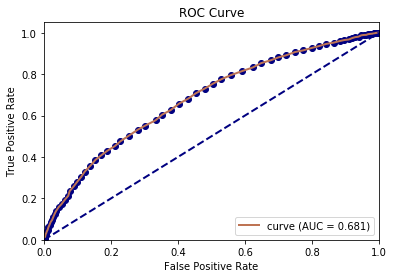

0.6808604823132954

In [21]:
#%% assess accuracy
pred = rfc.predict_proba(X_test_red)[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
sklearn.metrics.auc(fpr, tpr)
t=y.value_counts()[1]/y.value_counts().sum()
sklearn.metrics.f1_score(y_test, pred>t)
sklearn.metrics.accuracy_score(y_test, pred>t)

roc_auc(pred, y_test)

In [22]:
#TODO - visualize accuracy metrics based on threshold
pd.options.mode.chained_assignment = None
pred = rfc.predict_proba(X_test_red)[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
sklearn.metrics.auc(fpr, tpr)

0.6808604823132954

In [23]:
df_res['accuracy'] = df_res.threshold.apply(lambda t: sklearn.metrics.accuracy_score(y_test, pred>t))
df_res['precision'] = df_res.threshold.apply(lambda t: sklearn.metrics.precision_score(y_test, pred>t))
df_res['recall'] = df_res.threshold.apply(lambda t: sklearn.metrics.recall_score(y_test, pred>t))
df_res['f1'] = df_res.threshold.apply(lambda t: sklearn.metrics.f1_score(y_test, pred>t))
df_res['specificity'] = df_res.fpr.apply(lambda fpr: 1-fpr)

pt_opt = df_res[df_res.f1 == df_res.f1.max()].iloc[0]
pt_opt

C:\Users\xiaoyzhu.REDMOND\AppData\Local\Continuum\anaconda3\envs\azureml\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xiaoyzhu.REDMOND\AppData\Local\Continuum\anaconda3\envs\azureml\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


threshold      0.360000
fpr            0.677419
tpr            0.867130
accuracy       0.582600
precision      0.529079
recall         0.853235
f1             0.653149
specificity    0.322581
Name: 55, dtype: float64

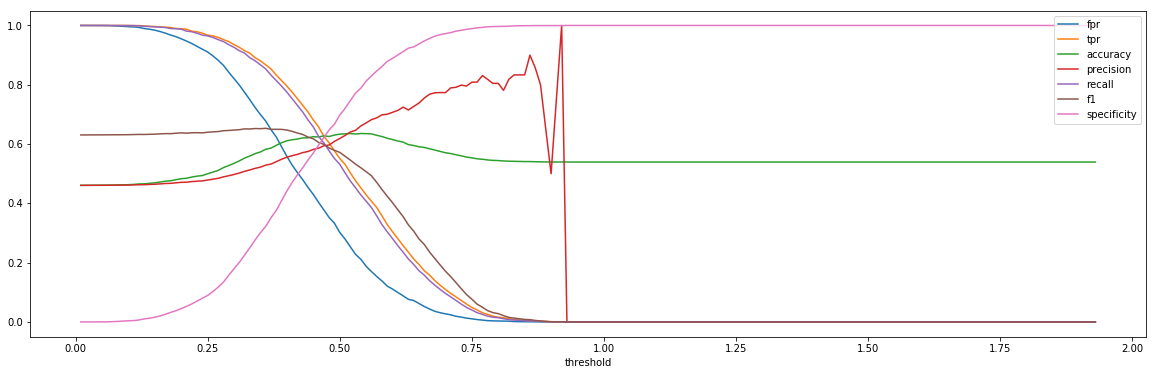

In [24]:
plt.rcParams["figure.figsize"] = (20,6)
df_res.plot(x='threshold')

# Generate Decision tree based on the top features

In [25]:
from sklearn.externals.six import StringIO  

dtc = DecisionTreeClassifier(min_samples_leaf=0.125, min_samples_split=0.125)
dtc.fit(X_train_red, y_train)
from sklearn import tree


In [26]:
from IPython.display import Image
from subprocess import check_call
tree.export_graphviz(dtc, out_file="tree.dot", feature_names=rf_feats, proportion=True)
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])
Image(filename='tree.png')

FileNotFoundError: [WinError 2] The system cannot find the file specified